In [ ]:
# https://www.kaggle.com/code/finlay/deepfake-ffdi-baseline

In [ ]:
!apt-get install -y -q google-cloud-sdk

from google.colab import auth
auth.authenticate_user()

import os
destination_folder = '/content/phase1/'
os.makedirs(destination_folder, exist_ok=True)

source_folder = 'gs://deep_fake_dataset-1/Image/phase1/'

!gsutil -m cp -r {source_folder} {destination_folder}

Streaming output truncated to the last 5000 lines.
Copying gs://deep_fake_dataset-1/Image/phase1/valset/f7463a387c0b6eba3d2fb0c31192a097.jpg...
Copying gs://deep_fake_dataset-1/Image/phase1/valset/f74691693a23e363483adc4999a14b8a.jpg...
Copying gs://deep_fake_dataset-1/Image/phase1/valset/f7480af3832bffddeca4689fedc705a7.jpg...
Copying gs://deep_fake_dataset-1/Image/phase1/valset/f7483b095f6e1be26a68ee09f354f002.jpg...
Copying gs://deep_fake_dataset-1/Image/phase1/valset/f7488167c2a04afb17bab82faea9a7a5.jpg...
Copying gs://deep_fake_dataset-1/Image/phase1/valset/f7489b15ce273a6fe8137b36892adad3.jpg...
Copying gs://deep_fake_dataset-1/Image/phase1/valset/f748e330333cc95913525ffcea14edbc.jpg...
Copying gs://deep_fake_dataset-1/Image/phase1/valset/f74979d81323d8c1de7d7b11249fb5aa.jpg...
Copying gs://deep_fake_dataset-1/Image/phase1/valset/f74c23c5449ca230a6f610fafa5d8465.jpg...
Copying gs://deep_fake_dataset-1/Image/phase1/valset/f74c9e1912517e9289f9bec8e102254a.jpg...
Copying gs://deep_f

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
import timm
import time

import pandas as pd
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm_notebook

import os

train_label = pd.read_csv('/content/phase1/phase1/trainset_label.txt')
val_label = pd.read_csv('/content/phase1/phase1/valset_label.txt')

train_label['path'] = '/content/phase1/phase1/trainset/' + train_label['img_name']
val_label['path'] = '/content/phase1/phase1/valset/' + val_label['img_name']

print("Train...")
train_image_files = os.listdir("/content/phase1/phase1/trainset")
filtered_train_label = train_label[train_label['img_name'].isin(train_image_files)]

display(filtered_train_label.head(10))
display(filtered_train_label['target'].value_counts())

print("Validation...")
val_image_files = os.listdir("/content/phase1/phase1/valset")
filtered_val_label = val_label[val_label['img_name'].isin(val_image_files)]

display(filtered_val_label.head(10))
print(filtered_val_label["target"].value_counts())

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

class ProgressMeter(object):
    def __init__(self, num_batches, *meters):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = ""


    def pr2int(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, losses, top1)

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in tqdm_notebook(enumerate(val_loader), total=len(val_loader)):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc = (output.argmax(1).view(-1) == target.float().view(-1)).float().mean() * 100
            losses.update(loss.item(), input.size(0))
            top1.update(acc, input.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f}'
              .format(top1=top1))
        return top1

def predict(test_loader, model, tta=10):
    # switch to evaluate mode
    model.eval()

    test_pred_tta = None
    for _ in range(tta):
        test_pred = []
        with torch.no_grad():
            end = time.time()
            for i, (input, target) in tqdm_notebook(enumerate(test_loader), total=len(test_loader)):
                input = input.cuda()
                target = target.cuda()

                # compute output
                output = model(input)
                output = F.softmax(output, dim=1)
                output = output.data.cpu().numpy()

                test_pred.append(output)
        test_pred = np.vstack(test_pred)

        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred

    return test_pred_tta

def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, losses, top1)

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        acc = (output.argmax(1).view(-1) == target.float().view(-1)).float().mean() * 100
        top1.update(acc, input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 500 == 0:
            progress.pr2int(i)

class FFDIDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label

        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, torch.from_numpy(np.array(self.img_label[index]))

    def __len__(self):
        return len(self.img_path)

import timm
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)
model = model.cuda()

train_loader = torch.utils.data.DataLoader(
    FFDIDataset(filtered_train_label['path'].reset_index(drop=True),
                filtered_train_label['target'].reset_index(drop=True),
            transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ), batch_size=32, shuffle=True, num_workers=4, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    FFDIDataset(filtered_val_label['path'].reset_index(drop=True),
                filtered_val_label['target'].reset_index(drop=True),
            transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ), batch_size=32, shuffle=False, num_workers=4, pin_memory=True
)

criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), 0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.85)
best_acc = 0.0
for epoch in range(3):
    scheduler.step()
    print('Epoch: ', epoch)

    train(train_loader, model, criterion, optimizer, epoch)
    val_acc = validate(val_loader, model, criterion)

    if val_acc.avg.item() > best_acc:
        best_acc = round(val_acc.avg.item(), 2)
        torch.save(model.state_dict(), f'./model_{best_acc}.pt')

Train...


,img_name,target,path
0,3381ccbc4df9e7778b720d53a2987014.jpg,1,/content/phase1/phase1/trainset/3381ccbc4df9e7...
1,63fee8a89581307c0b4fd05a48e0ff79.jpg,0,/content/phase1/phase1/trainset/63fee8a8958130...
2,7eb4553a58ab5a05ba59b40725c903fd.jpg,0,/content/phase1/phase1/trainset/7eb4553a58ab5a...
3,920085930764461878d67b71703778e8.jpg,1,/content/phase1/phase1/trainset/92008593076446...
4,f6320687a93ccb0c5fa892dc3361b804.jpg,1,/content/phase1/phase1/trainset/f6320687a93ccb...
5,74970d23dab29994ce4513f1c6faaaa5.jpg,1,/content/phase1/phase1/trainset/74970d23dab299...
6,db5faf8831a7005a1e898751090e8158.jpg,1,/content/phase1/phase1/trainset/db5faf8831a700...
7,860367254ffcf1c59e8bc7b51f5b28bd.jpg,1,/content/phase1/phase1/trainset/860367254ffcf1...
8,714120508739951d908b1a9f648abfbd.jpg,0,/content/phase1/phase1/trainset/71412050873995...
9,f4aaca48c439a4cd60b500f510682af1.jpg,1,/content/phase1/phase1/trainset/f4aaca48c439a4...


target
1    425043
0     99386
Name: count, dtype: int64

Validation...


,img_name,target,path
0,cd0e3907b3312f6046b98187fc25f9c7.jpg,1,/content/phase1/phase1/valset/cd0e3907b3312f60...
1,aa92be19d0adf91a641301cfcce71e8a.jpg,0,/content/phase1/phase1/valset/aa92be19d0adf91a...
2,5413a0b706d33ed0208e2e4e2cacaa06.jpg,0,/content/phase1/phase1/valset/5413a0b706d33ed0...
3,c90f2cfd5b5fd759febcdfa8ccade77b.jpg,1,/content/phase1/phase1/valset/c90f2cfd5b5fd759...
4,b9c3a3900c92767e2e9035765f5acb06.jpg,1,/content/phase1/phase1/valset/b9c3a3900c92767e...
5,e861870d8acddafcc07e529ee459a452.jpg,1,/content/phase1/phase1/valset/e861870d8acddafc...
6,b18fa89b2a8ebf0de89a1e0886d15e14.jpg,0,/content/phase1/phase1/valset/b18fa89b2a8ebf0d...
7,658042526e6d0c199adc7bfeb1f7c888.jpg,1,/content/phase1/phase1/valset/658042526e6d0c19...
8,a20cf2d7dea580d0affc4d85c9932479.jpg,1,/content/phase1/phase1/valset/a20cf2d7dea580d0...
9,8abede0b86d6afe899052b4e33bb05d9.jpg,0,/content/phase1/phase1/valset/8abede0b86d6afe8...


target
1    88281
0    59082
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch:  0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[    0/16389]	Time  4.648 ( 4.648)	Loss 2.4719e+00 (2.4719e+00)	Acc@1  46.88 ( 46.88)
[ 1000/16389]	Time  0.182 ( 0.184)	Loss 3.3645e-01 (4.5741e-01)	Acc@1  90.62 ( 84.12)
[ 2000/16389]	Time  0.186 ( 0.185)	Loss 3.1523e-01 (4.5171e-01)	Acc@1  90.62 ( 83.60)
[ 3000/16389]	Time  0.186 ( 0.185)	Loss 8.2906e-01 (4.7613e-01)	Acc@1  59.38 ( 82.62)
[ 4000/16389]	Time  0.188 ( 0.185)	Loss 4.9658e-01 (4.8847e-01)	Acc@1  84.38 ( 82.08)
[ 5000/16389]	Time  0.177 ( 0.185)	Loss 5.9337e-01 (4.9265e-01)	Acc@1  75.00 ( 81.85)
[ 6000/16389]	Time  0.179 ( 0.185)	Loss 5.5807e-01 (4.9618e-01)	Acc@1  75.00 ( 81.67)
[ 7000/16389]	Time  0.186 ( 0.185)	Loss 4.3916e-01 (4.9849e-01)	Acc@1  84.38 ( 81.57)
[ 8000/16389]	Time  0.185 ( 0.186)	Loss 4.8518e-01 (4.9816e-01)	Acc@1  68.75 ( 81.46)
[ 9000/16389]	Time  0.182 ( 0.186)	Loss 2.4870e-01 (4.8052e-01)	Acc@1  93.75 ( 81.63)
[10000/16389]	Time  0.183 ( 0.186)	Loss 2.0351e-01 (4.5498e-01)	Acc@1  87.50 ( 82.44)
[11000/16389]	Time  0.189 ( 0.186)	Loss 9.4113e-02 (4.

<ipython-input-4-af8d5f9cc03f>:97: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (input, target) in tqdm_notebook(enumerate(val_loader), total=len(val_loader)):


  0%|          | 0/4606 [00:00<?, ?it/s]

 * Acc@1 93.523
Epoch:  1
[    0/16389]	Time  0.539 ( 0.539)	Loss 1.3067e-02 (1.3067e-02)	Acc@1 100.00 (100.00)
[ 1000/16389]	Time  0.184 ( 0.186)	Loss 2.0880e-01 (9.1064e-02)	Acc@1  90.62 ( 96.51)
[ 2000/16389]	Time  0.185 ( 0.186)	Loss 1.5539e-01 (8.3910e-02)	Acc@1  93.75 ( 96.82)
[ 3000/16389]	Time  0.185 ( 0.186)	Loss 1.3522e-01 (8.2767e-02)	Acc@1  93.75 ( 96.86)
[ 4000/16389]	Time  0.186 ( 0.186)	Loss 2.6108e-01 (8.1249e-02)	Acc@1  90.62 ( 96.93)
[ 5000/16389]	Time  0.184 ( 0.186)	Loss 2.1170e-02 (7.9586e-02)	Acc@1 100.00 ( 97.01)
[ 6000/16389]	Time  0.188 ( 0.186)	Loss 7.5346e-02 (7.8355e-02)	Acc@1 100.00 ( 97.05)
[ 7000/16389]	Time  0.184 ( 0.186)	Loss 9.8445e-02 (7.7267e-02)	Acc@1  93.75 ( 97.09)
[ 8000/16389]	Time  0.184 ( 0.186)	Loss 2.0390e-02 (7.5918e-02)	Acc@1 100.00 ( 97.16)
[ 9000/16389]	Time  0.186 ( 0.186)	Loss 5.4216e-02 (7.4542e-02)	Acc@1  96.88 ( 97.21)
[10000/16389]	Time  0.182 ( 0.186)	Loss 2.6895e-01 (7.3145e-02)	Acc@1  90.62 ( 97.27)
[11000/16389]	Time  0.188 ( 

  0%|          | 0/4606 [00:00<?, ?it/s]

 * Acc@1 81.101
Epoch:  2
[    0/16389]	Time  0.436 ( 0.436)	Loss 1.0735e-01 (1.0735e-01)	Acc@1  96.88 ( 96.88)
[ 1000/16389]	Time  0.186 ( 0.186)	Loss 4.1137e-02 (5.2895e-02)	Acc@1  96.88 ( 98.13)
[ 2000/16389]	Time  0.186 ( 0.186)	Loss 2.5865e-02 (5.3290e-02)	Acc@1 100.00 ( 98.12)
[ 3000/16389]	Time  0.185 ( 0.186)	Loss 3.3537e-02 (5.2476e-02)	Acc@1  96.88 ( 98.14)
[ 4000/16389]	Time  0.186 ( 0.186)	Loss 4.9600e-02 (5.1702e-02)	Acc@1  96.88 ( 98.16)
[ 5000/16389]	Time  0.186 ( 0.186)	Loss 9.9793e-03 (5.1686e-02)	Acc@1 100.00 ( 98.15)
[ 6000/16389]	Time  0.183 ( 0.186)	Loss 3.7051e-02 (5.1608e-02)	Acc@1 100.00 ( 98.15)
[ 7000/16389]	Time  0.186 ( 0.186)	Loss 2.2463e-02 (5.1196e-02)	Acc@1 100.00 ( 98.16)
[ 8000/16389]	Time  0.187 ( 0.186)	Loss 1.8753e-02 (5.0872e-02)	Acc@1 100.00 ( 98.17)
[ 9000/16389]	Time  0.184 ( 0.186)	Loss 8.4786e-03 (5.0590e-02)	Acc@1 100.00 ( 98.18)
[10000/16389]	Time  0.189 ( 0.186)	Loss 3.9343e-02 (5.0563e-02)	Acc@1  96.88 ( 98.19)
[11000/16389]	Time  0.186 ( 

  0%|          | 0/4606 [00:00<?, ?it/s]

 * Acc@1 90.303


  0%|          | 0/4606 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        Real       0.90      0.94      0.92     59082
    DeepFake       0.96      0.93      0.95     88281

    accuracy                           0.94    147363
   macro avg       0.93      0.94      0.93    147363
weighted avg       0.94      0.94      0.94    147363



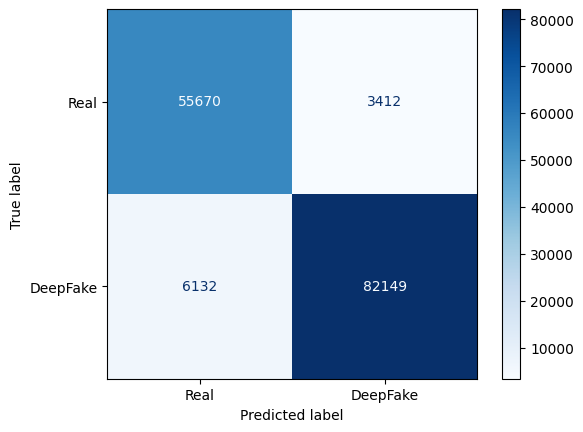

In [ ]:
import timm
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

def predict_label(val_loader, model):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for i, (input, target) in tqdm(enumerate(val_loader), total=len(val_loader)):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            all_preds.append(output.argmax(1).cpu().numpy())
            all_targets.append(target.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    return all_preds, all_targets

def generate_classification_report(val_loader, model):
    all_preds, all_targets = predict_label(val_loader, model)

    report = classification_report(all_targets, all_preds, target_names=['Real', 'DeepFake'])
    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'DeepFake'])

    print(report)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Load the model
model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=2)
model = model.cuda()  # Move the model to GPU if available
model.load_state_dict(torch.load(f'./model_{best_acc}.pt'))

# Generate and display the classification report for the validation dataset on GPU
generate_classification_report(val_loader, model)